# 앙상블 (Ensemble)
- 다양한 모델을 결합하여 예측 성능을 향상시키는 방법
- 투표(Voting), 배깅(Bagging), 부스팅(Boosting), 스태킹(Stacking) 네 가지로 구분

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
import warnings
warnings.filterwarnings('ignore')

### Voting
- hard voting : 여러 개의 예측치에 대해 다수결로 결정
- soft voting : 여러 개의 예측 확률을 평균내어 결정

##### 위스콘신 유방암 데이터셋 (Wisconsin Breast Cancer Dataset)

유방암의 악성(Malignant)과 양성(Benign)을 분류하기 위해 자주 사용되는 데이터셋
(의학적인 이미지를 바탕으로 유방암 종양의 특징을 수치화한 데이터)

**데이터셋 개요**
- **목적**: 유방암 종양이 악성(Malignant)인지, 양성(Benign)인지 분류
- **샘플 수**: 569개
- **특징(Features) 수**: 30개
- **타겟(Target)**: 0(악성) 또는 1(양성)

**데이터 구성**
1. **Radius mean**: 종양의 평균 반지름
2. **Texture mean**: 종양의 표면의 거칠기
3. **Perimeter mean**: 종양의 평균 둘레 길이
4. **Area mean**: 종양의 평균 면적
5. **Smoothness mean**: 종양의 매끄러움 정도
6. **Compactness mean**: 종양의 압축도
7. **Concavity mean**: 종양의 오목함
8. **Concave points mean**: 종양의 오목한 점 개수
9. **Symmetry mean**: 종양의 대칭성
10. **Fractal dimension mean**: 종양의 프랙탈 차원 

In [44]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
# print(data.DESCR)

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [46]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [47]:
# 데이터 준비 (분리)
from sklearn.model_selection import train_test_split

X = data.data
y = data.target


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### hard voting

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)
    ],
    voting='hard'   # 기본값
)

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred_train = voting_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print("학습 점수: ", acc_score_train)

y_pred_test = voting_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print("테스트 평가 점수: ", acc_score_test)

학습 점수:  0.9647887323943662
테스트 평가 점수:  0.958041958041958


In [49]:
# hard voting 작동 원리 == 다수결
start, end = 40, 50

voting_clf_pred = voting_clf.predict(X_test[start:end])
print('앙상블 예측값: ', voting_clf_pred)

for classifier in [knn_clf, lr_clf, dt_clf]:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    acc_score = accuracy_score(y_test, pred)

    class_name = classifier.__class__.__name__  # 클래스의 이름 속성
    print(f'{class_name} 개별 정확도: {acc_score: .4f}')
    print(f'{class_name} 예측값: {pred[start:end]}')
    

앙상블 예측값:  [0 1 0 1 0 0 1 1 1 0]
KNeighborsClassifier 개별 정확도:  0.9371
KNeighborsClassifier 예측값: [0 1 0 1 0 0 1 1 1 0]
LogisticRegression 개별 정확도:  0.9580
LogisticRegression 예측값: [0 1 0 1 0 0 1 1 1 0]
DecisionTreeClassifier 개별 정확도:  0.8951
DecisionTreeClassifier 예측값: [0 1 0 1 0 0 1 0 1 0]


##### soft voting

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier(random_state=0)

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)
    ],
    voting='soft'  
)

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred_train = voting_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print("학습 점수: ", acc_score_train)

y_pred_test = voting_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print("테스트 평가 점수: ", acc_score_test)

학습 점수:  0.9859154929577465
테스트 평가 점수:  0.9370629370629371


In [51]:
# soft voting 작동 원리 == 각 예측기의 확률값 평균

start, end = 40, 50

voting_clf_pred_proba = voting_clf.predict_proba(X_test[start:end])
print('앙상블 예측값: ', voting_clf_pred_proba)

averages = np.full_like(voting_clf_pred_proba, 0)


for classifier in [knn_clf, lr_clf, dt_clf]:
    # 개별 학습 및 예측
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    acc_score = accuracy_score(y_test, pred)
    pred_proba = classifier.predict_proba(X_test[start:end])

    # 예측 확률 평균을 위한 합계
    averages += pred_proba

    class_name = classifier.__class__.__name__  # 클래스의 이름 속성
    # print(f'{class_name} 개별 정확도: {acc_score: .4f}')
    # print(f'{class_name} 예측 확률: {pred_proba}')

# 예측 확률 평균 계산 및 출력
calc_averages = averages / 3
print("각 모델별 예측값 평균: ", calc_averages)
print(np.array_equal(voting_clf_pred_proba, calc_averages))

앙상블 예측값:  [[5.63929262e-01 4.36070738e-01]
 [1.02985506e-03 9.98970145e-01]
 [9.99175147e-01 8.24853002e-04]
 [4.58125048e-04 9.99541875e-01]
 [9.00868894e-01 9.91311059e-02]
 [1.00000000e+00 3.50628149e-12]
 [1.16695299e-04 9.99883305e-01]
 [2.09777037e-02 9.79022296e-01]
 [1.43497958e-03 9.98565020e-01]
 [9.32900367e-01 6.70996333e-02]]
각 모델별 예측값 평균:  [[5.63929262e-01 4.36070738e-01]
 [1.02985506e-03 9.98970145e-01]
 [9.99175147e-01 8.24853002e-04]
 [4.58125048e-04 9.99541875e-01]
 [9.00868894e-01 9.91311059e-02]
 [1.00000000e+00 3.50628149e-12]
 [1.16695299e-04 9.99883305e-01]
 [2.09777037e-02 9.79022296e-01]
 [1.43497958e-03 9.98565020e-01]
 [9.32900367e-01 6.70996333e-02]]
True


### Bagging
- Bootstrap Aggregation
- Bootstrap 방식의 샘플링: 각 estimator 마다 훈련 데이터를 뽑을 때, 중복 값을 허용하는 방식
- 분류 모델의 경우, 각 tree(estimator)의 예측값을 다수결(hard voting) 결정
- 회귀 모델의 경우, 각 tree(extimator)의 예측값을 평균내어 결정
- 기본적으로 100개의 tree 사용

**하이퍼 파라미터**
| **하이퍼파라미터**      | **설명**                                                                                     | **기본값**      |
|--------------------------|--------------------------------------------------------------------------------------------|-----------------|
| `n_estimators`           | 생성할 트리의 개수 지정 (트리의 개수가 많을수록 성능이 좋아질 수 있지만 계산 비용 증가) | 100             |
| `criterion`              | 분할 품질을 측정하는 기준 (분류에서는 "gini" 또는 "entropy"를 사용)                 | "gini"          |
| `max_depth`              | 각 트리의 최대 깊이 (설정하지 않으면 트리는 잎 노드가 순수해질 때까지 계속 확장) | None            |
| `min_samples_split`      | 내부 노드를 분할하기 위해 필요한 최소 샘플 수 (과적합 방지 목적)                   | 2               |
| `min_samples_leaf`       | 잎 노드가 되기 위해 필요한 최소 샘플 수 (과적합 방지 목적)                          | 1               |
| `max_features`           | 각 트리를 분할할 때 고려할 최대 특성 수 ()"auto", "sqrt", "log2" 중 선택하거나, 특정 숫자 지정 가능) | "auto"          |
| `bootstrap`              | 각 트리를 만들 때 부트스트랩 샘플링을 사용할지 여부를 결정                               | True            |
| `random_state`           | 결과의 재현성을 위해 난수 시드 고정                                                  | None            |
| `n_jobs`                 | 병렬 계산을 위해 사용할 CPU 코어 수를 지정 (-1로 설정하면 모든 코어를 사용)           | None            |
| `class_weight`           | 각 클래스의 가중치를 자동으로 계산하거나 직접 지정 가능 (불균형 데이터 처리에 유용)    | None            |


In [52]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=7 ,random_state=0)

# 학습
rf_clf.fit(X_train, y_train)

y_pred_train = rf_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

y_pred_test = rf_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)

학습 점수: 0.9976525821596244
테스트 평가 점수: 0.9790209790209791


In [53]:
# 100개의 DecisionTree 확인
# print(rf_clf.estimators_)

# 100개의 DecisionTree가 사용한 샘플데이터 확인
print(len(rf_clf.estimators_samples_[0]))

426


In [54]:
pd.Series(rf_clf.feature_importances_,index=data.feature_names).sort_values(ascending=False)

worst perimeter            0.163547
worst radius               0.117308
worst concave points       0.114409
mean concave points        0.103391
worst area                 0.061882
mean concavity             0.056032
mean perimeter             0.054363
mean area                  0.048603
worst concavity            0.038035
area error                 0.032931
radius error               0.029419
mean radius                0.024379
mean texture               0.016010
perimeter error            0.014571
worst texture              0.014562
worst smoothness           0.013452
worst compactness          0.012360
worst symmetry             0.012320
worst fractal dimension    0.009725
mean compactness           0.008854
mean smoothness            0.007140
concave points error       0.006683
texture error              0.006609
mean symmetry              0.006366
concavity error            0.006181
symmetry error             0.004600
fractal dimension error    0.004589
compactness error          0

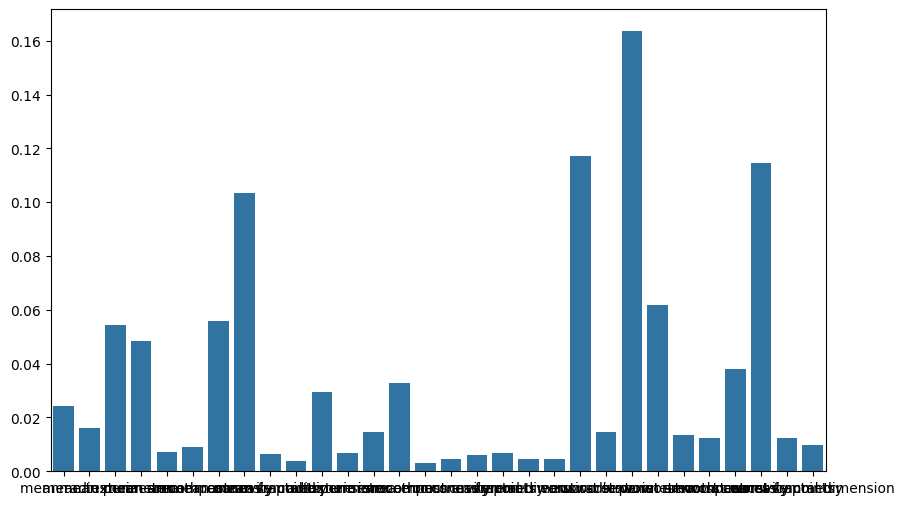

In [55]:
plt.figure(figsize=(10,6))
sns.barplot(x=data.feature_names, y=rf_clf.feature_importances_)
plt.show()

In [56]:
# 1. 데이터 로
train_data = pd.read_csv('./data/har_train.csv')
test_data = pd.read_csv('./data/har_test.csv')
train_data.shape,test_data.shape

((7352, 563), (2947, 563))

### Boosting
- 깊이가 얕은 결정트리를 사용해 이전 트리의 오차를 보정하는 방식
- 순차적으로 경사 하강법을 사용해 이전 트리의 오차를 줄여 나감
    - 분류 모델에서는 손실함수 Logloss를 사용해 오차를 ㅜㅈㄹ임
    - 회귀 모델에서는 손실함수 MSE를 사용해 오차를 줄임
- Boosting 계열은 일반적으로 결정트리 개수를 느려도 과적합에 강함
- 대표적인 알고리즘(모델) : GradientBoosting
HistGradientBoosting, XGBoost(DMLC),LightGBM(MS), CatBoost

##### GradientBoosting 구현

In [57]:
from sklearn.tree import DecisionTreeRegressor

In [58]:
def __init__(self,n_estimators=100,learning_rate=0.1,max_depth=3,random_state=0):
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.random_state = random_state
    self.model = None
def sigmoid(self,x):
    return 1/(1+np.exp(-x))
def log_odds(self,p):
    # 확률값 -> 로짓 변환 : 0~1 사이의 값을 펼쳐 무한대와 음의 무한대 사이의 값으로 변환
    return np.log(p/(1-p))

def fit(self,X,y):
        y_mean = np.mean(y)
        self.initial_log_odds = self.log_odds(y_mean)
        y_pred_log_odds = np.full_like(y,self.initial_log_odds,dtype=np.float64)
        for _ in range(self.n_estimators):
            y_pred_proba = self.sigmoid(y_pred_log_odds)
            residuals = y - y_pred_proba
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X,residuals)
            self.trees.append(tree)
            # 예측값 업데이트 (예측값 점진적 개선)
            y_pred_log_odds +=  + self.learning_rate * tree.predict(X)
            
            
            
def predict(self,x):
    return (self.predict_proba(x) > 0.5).astype(int)

def predict_proba(self,x):
    y_pred_log_odds = np.full(x.shape[0],self.initial_log_odds)
    for tree in self.trees:
        y_pred_log_odds += self.learning_rate * tree.predict(x)
    return self.sigmoid(y_pred_log_odds)




##### GraientBoostingClassifier

In [59]:
# GraientBoostingClassifier로 유방암 데이터 예측
from sklearn.ensemble import GradientBoostingClassifier
#데이터 로드 및 분리
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)

gb_clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.01,max_depth=3)
gb_clf.fit(X_train,y_train)

y_pred_train = gb_clf.predict(X_train)
acc_score_train = accuracy_score(y_train,y_pred_train)
print('학습 정확도:',acc_score_train)
print('평가 정확도:',accuracy_score(y_test,y_pred_test))


학습 정확도: 0.9882629107981221
평가 정확도: 0.9790209790209791


##### HistGradientBoosting
- 고성능 Gradient Boosting 모델로 대규모 데이터셋 처리에 적합
- Histogram 기반으로 256개의 구간으로 나누어 처리 병합하는 방식
- 결측치가 잇어도 전처리가 필요 없음
- LightGBM의 영향을 받아 만들어진 scikit-learn의 모델

In [60]:
from sklearn.ensemble import HistGradientBoostingClassifier

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=42)

hist_gb_clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    max_bins=255,           #255개의 구간으로 나누어 처리
    early_stopping=True,   # 반복 중 '일정 횟수' 이상 성능 향상이 없으면 학습 종료
    n_iter_no_change=5      # '일정 횟수' 지정 (기본값 : 10) 
    )
hist_gb_clf.fit(X_train,y_train)

y_pred_train = hist_gb_clf.predict(X_train)
y_pred_test = hist_gb_clf.predict(X_test)

print('학습 정확도:',accuracy_score(y_train,y_pred_train))
print('평가 정확도:',accuracy_score(y_test,y_pred_test))






학습 정확도: 0.9976525821596244
평가 정확도: 0.965034965034965


In [61]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data,diabetes.target,random_state=0)

In [62]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score

hist_gb_reg = HistGradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=3,
    max_bins=255,
    early_stopping=True,
    
)
hist_gb_reg.fit(X_train,y_train)

y_pred_train = hist_gb_reg.predict(X_train)
y_pred_test = hist_gb_reg.predict(X_test)
print(f'학습 MSE : {mean_squared_error(y_train,y_pred_train):.4f}')
print(f'테스트 MSE : {mean_squared_error(y_test,y_pred_test):.4f}')


학습 MSE : 1797.5523
테스트 MSE : 3753.5500


In [63]:
from sklearn.model_selection import GridSearchCV
hist_gb_reg = HistGradientBoostingRegressor(random_state=0)
param_grid = {
    'learning_rate':[0.01,0.05,0.1],
    'max_depth':[1,3,5],
    'min_samples_leaf':[10,20,30],
    'l2_regularization':[0,0.01,0.1],
    'max_bins':[255,127]
}
grid_search = GridSearchCV(
    hist_gb_reg,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    
)
grid_search.fit(X_train,y_train)
grid_search.best_params_

{'l2_regularization': 0.1,
 'learning_rate': 0.1,
 'max_bins': 127,
 'max_depth': 1,
 'min_samples_leaf': 20}

In [64]:
best_hist_gb_reg = grid_search.best_estimator_

y_pred_train = best_hist_gb_reg.predict(X_train)
y_pred_test = best_hist_gb_reg.predict(X_test)

print(f'학습 MSE : {mean_squared_error(y_train,y_pred_train):.4f} 학습 R2 : {r2_score(y_train,y_pred_train):.4f}')
print(f'테스트 MSE : {mean_squared_error(y_test,y_pred_test):.4f} 테스트 R2 : {r2_score(y_test,y_pred_test):.4f}')



학습 MSE : 2358.1851 학습 R2 : 0.6229
테스트 MSE : 3384.2348 테스트 R2 : 0.3183


In [65]:
#XGBoost

In [73]:
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data,iris.target,random_state=0)

xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=0    
)
xgb_clf.fit(X_train,y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)

print(f'학습 정확도 : {accuracy_score(y_train,y_pred_train)}')
print(f'테스트 정확도 : {accuracy_score(y_test,y_pred_test)}')

print(classification_report(y_test,y_pred_test))

학습 정확도 : 1.0
테스트 정확도 : 0.9736842105263158
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



In [77]:
# 유방암 데이터셋 이진 분류
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data,data.target,random_state=0)

xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=0
)
xgb_clf.fit(X_train,y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)


In [81]:
# XGBClassifier에 조기 종료 적용 -> 과적합 방지, 훈련시간 단축
xgb_clf = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.1,
    random_state=0,
    early_stopping_rounds=10, # 성능이 일정 횟수 이상 향상되지 않으면 조기 종료(반복을 중단함)
    eval_metrics=['logloss']
)
x_tr,x_val,y_tr,y_val = train_test_split(X_train,y_train,random_state=0)

eval_set = [(x_val,y_val)]

xgb_clf.fit(x_tr,y_tr,
            eval_set=eval_set,
            verbose=True)
# eval_set : 검증 데이터셋, verbose : 학습 평가 과정 출력 여부

[0]	validation_0-logloss:0.60855
[1]	validation_0-logloss:0.55458
[2]	validation_0-logloss:0.50524
[3]	validation_0-logloss:0.46295
[4]	validation_0-logloss:0.42707
[5]	validation_0-logloss:0.39923
[6]	validation_0-logloss:0.37175
[7]	validation_0-logloss:0.34858
[8]	validation_0-logloss:0.32846
[9]	validation_0-logloss:0.30968
[10]	validation_0-logloss:0.29418
[11]	validation_0-logloss:0.28202
[12]	validation_0-logloss:0.27007
[13]	validation_0-logloss:0.25975
[14]	validation_0-logloss:0.24955
[15]	validation_0-logloss:0.24042
[16]	validation_0-logloss:0.23337
[17]	validation_0-logloss:0.22497
[18]	validation_0-logloss:0.21875
[19]	validation_0-logloss:0.21374
[20]	validation_0-logloss:0.20948
[21]	validation_0-logloss:0.20090
[22]	validation_0-logloss:0.19452
[23]	validation_0-logloss:0.18731
[24]	validation_0-logloss:0.18402
[25]	validation_0-logloss:0.17873
[26]	validation_0-logloss:0.17608
[27]	validation_0-logloss:0.17421
[28]	validation_0-logloss:0.17230
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None,
              eval_metrics=['logloss'], feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)